In [12]:
import numpy as np
import matplotlib.pyplot as plt

import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

from pathlib import Path
from scipy.spatial import cKDTree
from itertools import combinations
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import TwoSlopeNorm
import time
from joblib import Parallel, delayed

In [13]:
# Generate 3D data: (x, y, L) where L is luminosity
# Points are connected via alpha filtration (max_alpha controls cutoff)
N_POINTS = 10000
MAX_ALPHA = 0.05
np.random.seed(42)
data_3d = np.random.uniform(-1, 1, (N_POINTS, 3))  # (x, y, L)
data_2d = data_3d[:, :2]  # Spatial coordinates (x, y) for plotting 
luminosity = data_3d[:, 2]  # Luminosity L - used for connectivity 

In [14]:
#import pandas as pd

#fake_path = Path("/Users/marxena/Desktop/Homology /fake_triangle_data.csv")
#fake_df = pd.read_csv(fake_path)

#if not {'x', 'y', 'luminosity'}.issubset(fake_df.columns):
 #   raise ValueError("fake_triangle_data.csv must contain columns 'x', 'y', and 'luminosity'")

#data_2d = fake_df[['x', 'y']].to_numpy()
#luminosity = fake_df['luminosity'].to_numpy()

#print(f"Loaded {len(fake_df)} vertices from {fake_path}")
#print(fake_df[['family', 'sample_id', 'vertex_id']].head())


In [15]:
#print(data_3d[0:5])
print(luminosity)


[ 0.46398788 -0.68801096  0.20223002 ... -0.75339159  0.49564842
 -0.48520404]


In [16]:
def compute_rmax_for_luminosity_connectivity(luminosity, percentile=40):
    """
    Compute rmax based on L distances using sampling.
    """
    n_samples = min(5000, max(1000, len(luminosity) * 3))
    indices = np.random.choice(n, size=(2, n_samples), replace=True)
    sample_dists = np.abs(luminosity[indices[0]] - luminosity[indices[1]])
    non_zero = sample_dists[sample_dists > 0]
    if len(non_zero) == 0:
        return 0.1
    return float(np.percentile(non_zero, percentile))



In [17]:
def _classify_triangles_by_luminosity(triangles, data_2d, luminosity):
    """Split triangles into left/right using luminosity-prioritized orientation."""
    if len(triangles) == 0:
        return [], [], {}

    tris_array = np.asarray(triangles, dtype=int)
    unique_mask = np.array([len(set(tri)) == 3 for tri in tris_array], dtype=bool)
    tris_array = tris_array[unique_mask]
    if tris_array.size == 0:
        return [], [], {}

    left, right = [], []
    cross_map = {}

    coords = np.asarray(data_2d, dtype=float)
    lum = np.asarray(luminosity, dtype=float)

    for tri in tris_array:
        lum_vals = lum[tri]
        order = np.argsort(-lum_vals, kind="mergesort")  # descending luminosity, stable
        a_idx, b_idx, c_idx = (int(tri[i]) for i in order)

        a = coords[a_idx]
        b = coords[b_idx]
        c = coords[c_idx]

        cross = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
        tri_key = tuple(sorted(int(x) for x in tri))
        cross_map[tri_key] = float(cross)
        if cross >= 0.0:
            right.append(tri_key)
        else:
            left.append(tri_key)

    return left, right, cross_map


def prepare_topology_2d(data_2d, luminosity=None, eps=None, rmax=None, max_alpha=None):
    """
    Pipeline: Build AlphaComplex from spatial coordinates using alpha filtration for connectivity.
    Triangle handedness determined by luminosity-weighted cross products.

    Parameters:
    - data_2d: (N, 2) array of spatial coordinates (x, y)
    - luminosity: (N,) array of L values. Required for handedness classification.
    - max_alpha: filtration cutoff; include simplices with alpha <= max_alpha. If None, keep all.
    - eps: optional override for maximum filtration value (defaults to max alpha in complex).
    - rmax: deprecated, kept for compatibility (ignored).

    Returns dict with connectivity and persistence information.
    """
    start_time = time.time()

    if luminosity is None:
        raise ValueError("luminosity (L) is required")

    alpha_cutoff = np.inf if max_alpha is None else float(max_alpha)

    alpha_complex = gd.AlphaComplex(points=data_2d)
    st = alpha_complex.create_simplex_tree()

    skeleton_data = [(tuple(s), float(f)) for s, f in st.get_skeleton(2)]
    if not skeleton_data:
        return {
            "st": st, "eps": 0.0, "edges": [], "tris": [],
            "left_tris": [], "right_tris": [], "st_L": gd.SimplexTree(), "st_R": gd.SimplexTree(),
            "L0": [], "L1": [], "R0": [], "R1": [], "triangle_cross": {},
        }

    simplices = []
    filtrations = []
    for simplex, filt in skeleton_data:
        if filt <= alpha_cutoff:
            simplices.append(simplex)
            filtrations.append(filt)

    if not simplices:
        eps_val = 0.0 if eps is None else float(eps)
        return {
            "st": st, "eps": eps_val, "edges": [], "tris": [],
            "left_tris": [], "right_tris": [], "st_L": gd.SimplexTree(), "st_R": gd.SimplexTree(),
            "L0": [], "L1": [], "R0": [], "R1": [], "triangle_cross": {},
        }

    filtrations = np.array(filtrations, dtype=float)
    simplex_lengths = np.array([len(s) for s in simplices], dtype=int)

    edges = []
    edges_alpha = []
    triangles = []
    triangles_alpha = []
    triangles_ordered = []

    for simplex, length, filt in zip(simplices, simplex_lengths, filtrations):
        if length == 2:
            edges.append(tuple(sorted(int(x) for x in simplex)))
            edges_alpha.append(float(filt))
        elif length == 3:
            triangles.append(tuple(sorted(int(x) for x in simplex)))
            triangles_alpha.append(float(filt))
            triangles_ordered.append(tuple(int(x) for x in simplex))

    if eps is None:
        eps_val = float(np.max(filtrations)) if filtrations.size else 0.0
    else:
        eps_val = float(eps)

    print(f"Simplices within alpha≤{alpha_cutoff}: {len(edges)} edges, {len(triangles)} triangles")

    left_tris, right_tris, cross_map = _classify_triangles_by_luminosity(triangles_ordered, data_2d, luminosity)
    if triangles:
        filtered_tris = []
        filtered_alpha = []
        for tri, alpha in zip(triangles, triangles_alpha):
            if tri in cross_map:
                filtered_tris.append(tri)
                filtered_alpha.append(alpha)
        triangles = filtered_tris
        triangles_alpha = filtered_alpha

    edge_to_alpha = {edge: alpha for edge, alpha in zip(edges, edges_alpha)}

    triangle_edge_set = set()
    if triangles:
        for tri in triangles:
            a, b, c = int(tri[0]), int(tri[1]), int(tri[2])
            triangle_edge_set.add(tuple(sorted((a, b))))
            triangle_edge_set.add(tuple(sorted((a, c))))
            triangle_edge_set.add(tuple(sorted((b, c))))
    line_edges = [edge for edge in edges if edge not in triangle_edge_set]
    line_edges_alpha = [edge_to_alpha[edge] for edge in line_edges]

    st_L, st_R = gd.SimplexTree(), gd.SimplexTree()

    for edge, alpha in edge_to_alpha.items():
        st_L.insert(edge, filtration=alpha)
        st_R.insert(edge, filtration=alpha)

    tri_to_alpha = {tri: alpha for tri, alpha in zip(triangles, triangles_alpha)}

    for tri in left_tris:
        st_L.insert(tri, filtration=tri_to_alpha.get(tri, eps_val))
    for tri in right_tris:
        st_R.insert(tri, filtration=tri_to_alpha.get(tri, eps_val))

    st_L.persistence(homology_coeff_field=2, min_persistence=0.0)
    st_R.persistence(homology_coeff_field=2, min_persistence=0.0)
    L0 = st_L.persistence_intervals_in_dimension(0)
    L1 = st_L.persistence_intervals_in_dimension(1)
    R0 = st_R.persistence_intervals_in_dimension(0)
    R1 = st_R.persistence_intervals_in_dimension(1)

    def _combine_diagrams(d0, d1):
        d0_arr = np.array(d0, dtype=float) if len(d0) > 0 else np.zeros((0, 2))
        d1_arr = np.array(d1, dtype=float) if len(d1) > 0 else np.zeros((0, 2))
        if d0_arr.size == 0:
            return d1_arr.tolist() if d1_arr.size > 0 else []
        if d1_arr.size == 0:
            return d0_arr.tolist() if d0_arr.size > 0 else []
        if d0_arr.ndim == 1:
            d0_arr = d0_arr.reshape(-1, 2)
        if d1_arr.ndim == 1:
            d1_arr = d1_arr.reshape(-1, 2)
        combined = np.vstack([d0_arr, d1_arr])
        return combined.tolist()

    L = _combine_diagrams(L0, L1)
    R = _combine_diagrams(R0, R1)

    elapsed = time.time() - start_time
    if elapsed > 10:
        print(f"Warning: Function took {elapsed:.2f}s (target: <10s)")
    else:
        print(f"Completed in {elapsed:.2f}s")

    return {
        "st": st, "eps": float(eps_val),
        "edges": edges, "tris": triangles,
        "left_tris": left_tris, "right_tris": right_tris,
        "line_edges": line_edges, "line_edges_alpha": line_edges_alpha,
        "triangle_cross": cross_map,
        "st_L": st_L, "st_R": st_R,
        "L": L, "R": R,
        "L0": L0, "L1": L1, "R0": R0, "R1": R1,
    }


In [18]:
res = prepare_topology_2d(data_2d, luminosity=luminosity, rmax=None, max_alpha=MAX_ALPHA)
print(f"\nResults (alpha filtration ≤ {MAX_ALPHA}, {N_POINTS} points):")
print(f"  eps={res['eps']:.5g}")
print(f"  edges={len(res['edges'])}, tris={len(res['tris'])} (gaps OK)")
print(f"  left_tris={len(res['left_tris'])}, right_tris={len(res['right_tris'])}, line_only_edges={len(res['line_edges'])}")
print(f"  number_of_vertices={len(data_2d)}")


Simplices within alpha≤0.05: 29863 edges, 19864 triangles
Completed in 1.14s

Results (alpha filtration ≤ 0.05, 10000 points):
  eps=0.047919
  edges=29863, tris=19864 (gaps OK)
  left_tris=9930, right_tris=9934, line_only_edges=0
  number_of_vertices=10000


In [19]:

def plot_pd_gudhi_split(L, R, fname_prefix="pd_left_right", title_prefix="Persistence diagram"):
    """
    Plot separate images for Left and Right complexes.
    Accepts combined persistence diagrams (H0+H1 combined, no distinction).
    """
    def _finite_np(dgm):
        d = np.array(dgm, dtype=float)
        if d.size == 0: return d.reshape(0,2)
        if d.ndim == 1: d = d.reshape(-1,2)
        return d[np.isfinite(d).all(axis=1)]

    # Process combined diagrams (H0+H1 together)
    Lf = _finite_np(L)
    Rf = _finite_np(R)

    # Determine common limits (shared across all diagrams for fair comparison)
    def _lim(*arrs):
        mx = 0.0
        for a in arrs:
            if a.size:
                mx = max(mx, float(a.max()))
        return (mx*1.02) if mx > 0 and np.isfinite(mx) else 1.0

    lim = _lim(Lf, Rf)

    def _plot_single(ax, d, label, lim, color):
        xs = np.linspace(0.0, lim, 200)
        ax.plot(xs, xs, color="k", linewidth=1)
        ax.fill_between(xs, xs, lim, color="0.7", alpha=0.15)
        if d.size:
            ax.scatter(d[:,0], d[:,1], s=20, alpha=0.9, label=f"{label} (H0+H1)", color=color, edgecolors="none")
        ax.set_xlim(0, lim); ax.set_ylim(0, lim)
        ax.set_xlabel("Birth"); ax.set_ylabel("Death")
        ax.set_title(f"{title_prefix} — {label}")
        ax.legend(loc="lower right")

    # Left and Right complexes (combined H0+H1, no distinction)
    # Colors match simplicial complex: Left=red, Right=blue
    fig, axes = plt.subplots(1, 2, figsize=(9,4))
    _plot_single(axes[0], Lf, "Left", lim, "red")
    _plot_single(axes[1], Rf, "Right", lim, "blue")
    plt.tight_layout()
    plt.savefig(f"{fname_prefix}_left_right.png", dpi=160)
    plt.show()
    print("Saved", f"{fname_prefix}_left_right.png")


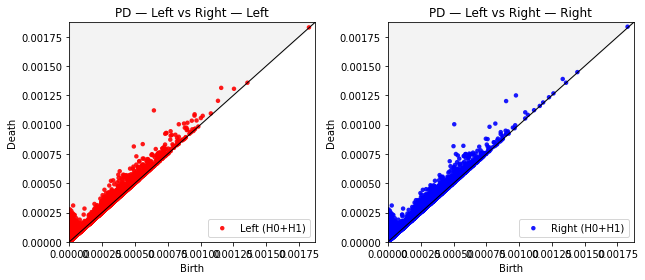

Saved pd_left_right_left_right.png


In [20]:
# Plot left vs right persistence diagrams
# Ensure we have L, R from the unified pipeline (combined H0+H1, no distinction)
try:
    L, R
except NameError:
    if 'prepare_topology_2d' in globals():
        lum = luminosity if 'luminosity' in globals() else None
        _res = prepare_topology_2d(data_2d, luminosity=lum, rmax=None, eps=None, max_alpha=MAX_ALPHA)
        L, R = _res["L"], _res["R"]
    else:
        raise

plot_pd_gudhi_split(L, R, fname_prefix="pd_left_right", title_prefix="PD — Left vs Right")


In [21]:

def plot_triangles_filled(ax, data_2d, edges, triangles, color, title):
    """
    Helper function to plot edges and triangles with proper filling.
    Shows ALL edges (connecting all points) and filled triangles.
    """
    # Plot data points
    ax.scatter(data_2d[:, 0], data_2d[:, 1], c='black', marker='o', s=1, alpha=0.6)
    
    # Plot ALL edges (edges appear in both left and right diagrams)
    for edge in edges:
        if isinstance(edge, (tuple, list)) and len(edge) == 2:
            i, j = int(edge[0]), int(edge[1])
            a = data_2d[i]
            b = data_2d[j]
            # Draw edge as line
            ax.plot([a[0], b[0]], [a[1], b[1]], color='black', linewidth=0.2, alpha=0.4)
    
    # Plot and fill each triangle
    for tri in triangles:
        # Handle both tuples and lists
        if isinstance(tri, (tuple, list)) and len(tri) == 3:
            # Get vertex indices
            i, j, k = int(tri[0]), int(tri[1]), int(tri[2])
            # Get coordinates
            a = data_2d[i]
            b = data_2d[j]
            c = data_2d[k]
            # Fill triangle (Ax.fill with color and alpha=0.3)
            ax.fill([a[0], b[0], c[0]], [a[1], b[1], c[1]], color=color, alpha=0.3)
    
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")


def plot_combined_triangles(ax, data_2d, edges, left_tris, right_tris, title):
    """
    Helper function to plot both left and right triangles together
    Shows all edges, left triangles in red, and right triangles in blue.
    """
    # Plot data points
    ax.scatter(data_2d[:, 0], data_2d[:, 1], c='black', marker='o', s=1, alpha=0.6)
    
    # Plot ALL edges
    for edge in edges:
        if isinstance(edge, (tuple, list)) and len(edge) == 2:
            i, j = int(edge[0]), int(edge[1])
            a = data_2d[i]
            b = data_2d[j]
            # Draw edge as line
            ax.plot([a[0], b[0]], [a[1], b[1]], color='black', linewidth=0.2, alpha=0.4)
    
    # Plot and fill left-handed triangles (red)
    for tri in left_tris:
        if isinstance(tri, (tuple, list)) and len(tri) == 3:
            i, j, k = int(tri[0]), int(tri[1]), int(tri[2])
            a = data_2d[i]
            b = data_2d[j]
            c = data_2d[k]
            ax.fill([a[0], b[0], c[0]], [a[1], b[1], c[1]], color='red', alpha=0.15)
    
    # Plot and fill right-handed triangles (blue)
    for tri in right_tris:
        if isinstance(tri, (tuple, list)) and len(tri) == 3:
            i, j, k = int(tri[0]), int(tri[1]), int(tri[2])
            a = data_2d[i]
            b = data_2d[j]
            c = data_2d[k]
            ax.fill([a[0], b[0], c[0]], [a[1], b[1], c[1]], color='blue', alpha=0.15)
    
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")


def auto_plot_handedness_2d(
    data_2d,
    luminosity=None,
    handedness="left",
    rmax=None,
    eps=None,
    max_alpha=None,
    title_prefix="2D complex",
    out=None,
    face_alpha=0.30,
    separate_plots=True,
):
    """
    Pipeline: form simplicial complex using AlphaComplex, plot with proper triangle filling.
    Creates three plots when separate_plots=True: left-only, right-only, and combined
    
    Parameters:
    - separate_plots: If True, creates three separate figures:
        1. Left-handed triangles only (red)
        2. Right-handed triangles only (blue)
        3. Combined Alpha Complex (both left and right together)
      If False, creates single plot with chosen handedness (default: True)
    - Other parameters same as before
    """
    if luminosity is None:
        raise ValueError("luminosity (L) is required")
    res = prepare_topology_2d(data_2d, luminosity=luminosity, eps=eps, rmax=rmax, max_alpha=max_alpha)
    
    st = res["st"]
    eps = res["eps"]
    edges = res["edges"]
    tris = res["tris"]
    left_tris = res["left_tris"]
    right_tris = res["right_tris"]

    # Convert to lists if needed
    if isinstance(left_tris, np.ndarray):
        left_tris = left_tris.tolist()
    if isinstance(right_tris, np.ndarray):
        right_tris = right_tris.tolist()

    if separate_plots:
        out_path = Path(out) if out else None
        if out_path:
            out_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Create three plots: left-only, right-only, and combined 
        # Left-handed triangles only (with ALL edges)
        fig_left, ax_left = plt.subplots(figsize=(8, 8))
        plot_triangles_filled(ax_left, data_2d, edges, left_tris, 'red', 
                             f"{title_prefix} — Left-handed Triangles (#{len(left_tris)} triangles, #{len(edges)} edges)")
        plt.tight_layout()
        if out_path:
            out_left = out_path.with_name(f"{out_path.stem}_left{out_path.suffix}")
            plt.savefig(out_left, dpi=160, bbox_inches='tight')
        plt.show()
        
        # Right-handed triangles only (with ALL edges)
        fig_right, ax_right = plt.subplots(figsize=(8, 8))
        plot_triangles_filled(ax_right, data_2d, edges, right_tris, 'blue', 
                             f"{title_prefix} — Right-handed Triangles (#{len(right_tris)} triangles, #{len(edges)} edges)")
        plt.tight_layout()
        if out_path:
            out_right = out_path.with_name(f"{out_path.stem}_right{out_path.suffix}")
            plt.savefig(out_right, dpi=160, bbox_inches='tight')
        plt.show()
        
        # Combined plot: both left and right triangles together 
        fig_combined, ax_combined = plt.subplots(figsize=(8, 8))
        plot_combined_triangles(ax_combined, data_2d, edges, left_tris, right_tris,
                               f"{title_prefix} — Alpha Complex (L={len(left_tris)}, R={len(right_tris)}, E={len(edges)})")
        plt.tight_layout()
        if out_path:
            out_combined = out_path.with_name(f"{out_path.stem}_combined{out_path.suffix}")
            plt.savefig(out_combined, dpi=160, bbox_inches='tight')
        plt.show()
    else:
        # Single plot with chosen handedness (backward compatibility)
        chosen = left_tris if handedness == "left" else right_tris
        color  = "red" if handedness == "left" else "blue"
        label  = "Left-handed" if handedness == "left" else "Right-handed"
        
        fig, ax = plt.subplots(figsize=(8, 8))
        plot_triangles_filled(ax, data_2d, edges, chosen, color, 
                             f"{title_prefix} — {label} (#{len(chosen)} triangles, #{len(edges)} edges)")
        plt.tight_layout()
        if out:
            out_path = Path(out)
            out_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(out_path, dpi=160, bbox_inches='tight')
        plt.show()

    return {
        "st": st,
        "eps": eps,
        "edges": edges,
        "tris": tris,
        "left_tris": left_tris,
        "right_tris": right_tris,
    }


Simplices within alpha≤0.05: 29863 edges, 19864 triangles
Completed in 1.10s


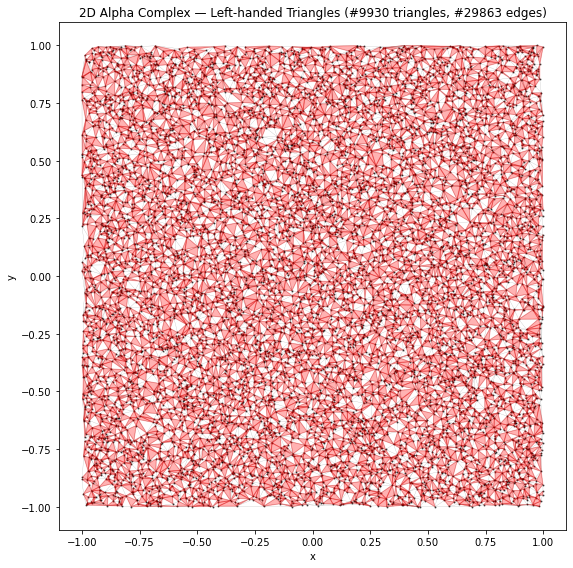

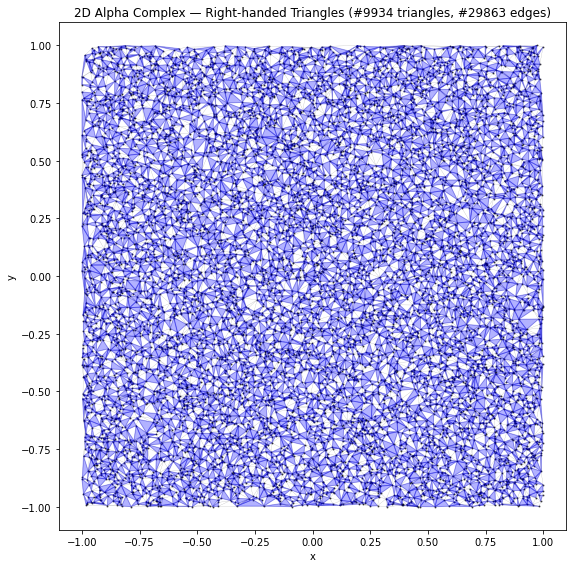

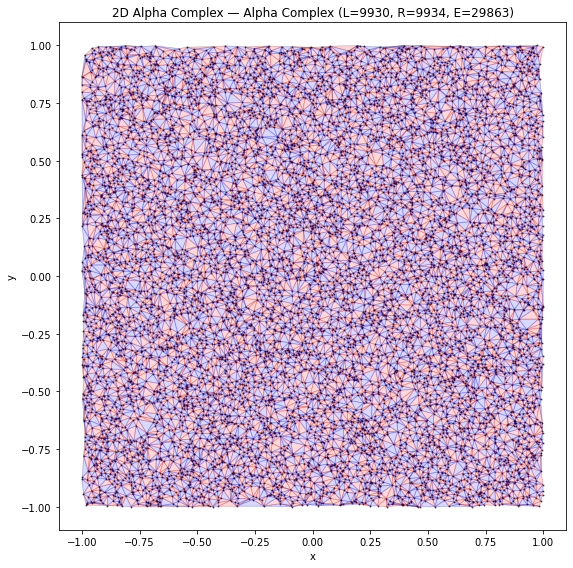

{'edges': 29863, 'tris': 19864, 'left_tris': 9930, 'right_tris': 9934}

AlphaComplex: Geometrically valid simplicial complex
Triangles properly filled using ax.fill()


In [22]:
res = auto_plot_handedness_2d(data_2d, luminosity=luminosity, rmax=None, max_alpha=MAX_ALPHA,
                               title_prefix="2D Alpha Complex", out="/Users/marxena/Desktop/Homology /simplicial_complex.png", separate_plots=True)
print({k: len(res[k]) if isinstance(res[k], list) else type(res[k]).__name__ for k in ["edges","tris","left_tris","right_tris"]})
print(f"\nAlphaComplex: Geometrically valid simplicial complex")
print(f"Triangles properly filled using ax.fill()")

In [23]:
def split_by_handedness(data_2d, tris, luminosity):
    """Split triangles using luminosity-weighted cross products."""
    if not tris:
        return [], []
    left, right, _ = _classify_triangles_by_luminosity(tris, data_2d, luminosity)
    return left, right


In [24]:
if not hasattr(np, "float"):   np.float = float
if not hasattr(np, "int"):     np.int = int
if not hasattr(np, "bool"):    np.bool = bool
if not hasattr(np, "complex"): np.complex = complex
if not hasattr(np, "object"):  np.object = object
    
# Ensure st exists and matches current data; rebuild if needed
# Always rebuild to ensure st matches current data_2d size
# (Previous st might have been built with different data)
lum = luminosity if 'luminosity' in globals() else None
_res = prepare_topology_2d(data_2d, luminosity=lum, rmax=None, eps=None, max_alpha=MAX_ALPHA)
st = _res["st"]; L=_res["L"]; R=_res["R"]

tri_simplices = [(tuple(s), float(f)) for s, f in st.get_skeleton(2) if len(s) == 3]
tri_indices   = [t for t, _ in tri_simplices]
tri_filts     = {frozenset(t): f for t, f in tri_simplices}

left_tris, right_tris = split_by_handedness(data_2d, tri_indices, luminosity)
left_tris  = left_tris  or []
right_tris = right_tris or []

<ipython-input-24-8514909c56e9>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasattr(np, "float"):   np.float = float
<ipython-input-24-8514909c56e9>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasat

Simplices within alpha≤0.05: 29863 edges, 19864 triangles
Completed in 1.15s


In [25]:
def _finite_np(diag):
    d = np.array(diag, dtype=float)
    if d.size == 0:
        return d.reshape(0, 2)
    if d.ndim == 1:
        d = d.reshape(-1, 2)
    mask = np.isfinite(d).all(axis=1)   # drop essential (∞) points
    return d[mask]

# Ensure persistence arrays exist (combined H0+H1, no distinction)
try:
    L, R
except NameError:
    lum = luminosity if 'luminosity' in globals() else None
    _res = prepare_topology_2d(data_2d, luminosity=lum, rmax=None, max_alpha=MAX_ALPHA)
    L, R = _res["L"], _res["R"]

Ln = _finite_np(L)
Rn = _finite_np(R)

# Compute Wasserstein distance on combined diagrams (H0+H1 together)
W = wasserstein_distance(Ln, Rn, order=1, internal_p=1)

print({
    "triangles_total": len(tri_indices),
    "left_triangles":  len(left_tris),
    "right_triangles": len(right_tris),
    "Wasserstein_W1": float(W),  # Combined H0+H1
})


{'triangles_total': 19979, 'left_triangles': 9989, 'right_triangles': 9990, 'Wasserstein_W1': 0.01736647260198331}


In [26]:
def subtract_diagrams_combined(dgmL, dgmR, order=1, internal_p=1, tol_decimals=None):
    """
    Combined, vectorized routine that:
      - filters finite points
      - optionally rounds to tol_decimals and computes set-style differences (vectorized)
      - computes Wasserstein matching and returns vectorized deltas and unmatched
    Returns dict with keys:
      L_finite, R_finite, W, pairs (i,j,db,dd), L_unmatched, R_unmatched,
      and if tol_decimals is not None: L_only_set, R_only_set
    """
    # finite extractor (vectorized)
    def _finite_np(dgm):
        d = np.array(dgm, dtype=float)
        if d.size == 0:
            return d.reshape(0, 2)
        if d.ndim == 1:
            d = d.reshape(-1, 2)
        m = np.isfinite(d).all(axis=1)
        return d[m]

    L = _finite_np(dgmL)
    R = _finite_np(dgmR)

    out = {"L_finite": L, "R_finite": R}

    # optional set-style differences via rounding (vectorized, no Python loops)
    if tol_decimals is not None:
        if L.size:
            Lr = np.round(L, tol_decimals)
        else:
            Lr = L
        if R.size:
            Rr = np.round(R, tol_decimals)
        else:
            Rr = R
        # use structured dtype so rows are hashable for set-like ops via numpy
        def _as_struct(a):
            if a.size == 0:
                return a.view([("b", float), ("d", float)])
            return a.view([("b", a.dtype), ("d", a.dtype)]).reshape(-1)
        Ls = _as_struct(Lr)
        Rs = _as_struct(Rr)
        # set differences via numpy
        L_only_struct = np.setdiff1d(Ls, Rs, assume_unique=False)
        R_only_struct = np.setdiff1d(Rs, Ls, assume_unique=False)
        L_only = L_only_struct.view(Lr.dtype).reshape(-1, 2) if L_only_struct.size else np.zeros((0,2))
        R_only = R_only_struct.view(Rr.dtype).reshape(-1, 2) if R_only_struct.size else np.zeros((0,2))
        out.update({"L_only_set": L_only, "R_only_set": R_only})

    # ============================================================================
    # WASSERSTEIN SUBTRACTION SECTION
    # ============================================================================
    # This computes the optimal transport (Wasserstein) matching between the two
    # persistence diagrams L and R, then performs "subtraction" by computing
    # the differences between matched points.
    #
    # The Wasserstein distance finds the optimal matching that minimizes the
    # total cost of moving mass from diagram L to diagram R.
    # Each point can be matched to:
    #   1. Another point (i >= 0, j >= 0): both points exist in both diagrams
    #   2. The diagonal (i >= 0, j == -1): point exists only in L
    #   3. The diagonal (j >= 0, i == -1): point exists only in R
    # ============================================================================
    
    # Edge case: both diagrams empty
    if L.size == 0 and R.size == 0:
        out.update({
            "W": 0.0,
            "pairs": [],
            "L_unmatched": np.zeros((0,2)),
            "R_unmatched": np.zeros((0,2)),
        })
        return out

    # STEP 1: Compute Wasserstein distance and get optimal matching
    # This is the CORE Wasserstein subtraction operation:
    # - wasserstein_distance computes the W_p distance (p=order) between diagrams
    # - matching=True returns the optimal matching: list of (i, j) pairs
    #   where i is index in L, j is index in R (or -1 if matched to diagonal)
    # - The matching minimizes total transport cost between persistence points
    W, matching = wasserstein_distance(L, R, order=order, internal_p=internal_p, matching=True)
    matching = np.asarray(matching, dtype=int)
    
    # STEP 2: Extract matching indices
    # matching is shape (n_matches, 2) where each row is [i, j]
    i_idx = matching[:,0]  # indices into L diagram
    j_idx = matching[:,1]  # indices into R diagram (or -1 for diagonal)
    
    # STEP 3: Categorize matches into three types (vectorized boolean masks)
    both = (i_idx >= 0) & (j_idx >= 0)   # L[i] matched to R[j] (both exist)
    l_only = (i_idx >= 0) & (j_idx == -1) # L[i] matched to diagonal (only in L)
    r_only = (j_idx >= 0) & (i_idx == -1) # R[j] matched to diagonal (only in R)

    # STEP 4: Compute subtraction deltas for matched pairs
    # For pairs where both points exist (both=True), compute:
    #   Δbirth = L[i].birth - R[j].birth
    #   Δdeath = L[i].death - R[j].death
    # This is the "subtraction" of matched persistence points (vectorized, no loops)
    pairs = []
    if np.any(both):
        Li = L[i_idx[both]]  # matched points from L diagram
        Rj = R[j_idx[both]]   # matched points from R diagram
        deltas = Li - Rj      # element-wise subtraction: [Δbirth, Δdeath] for each match
        # Stack indices and deltas: each row is [i, j, Δbirth, Δdeath]
        pairs = np.column_stack([i_idx[both], j_idx[both], deltas[:,0], deltas[:,1]]).tolist()

    # STEP 5: Extract unmatched points (those matched to diagonal)
    # These are persistence points that appear in only one diagram
    L_unmatched = L[i_idx[l_only]] if np.any(l_only) else np.zeros((0,2))  # Points only in L
    R_unmatched = R[j_idx[r_only]] if np.any(r_only) else np.zeros((0,2))  # Points only in R

    out.update({
        "W": float(W),
        "pairs": pairs,
        "L_unmatched": L_unmatched,
        "R_unmatched": R_unmatched,
    })
    return out


In [27]:
# Verification: Check that subtract_diagrams_combined performs Wasserstein subtraction correctly
print("="*70)
print("WASSERSTEIN SUBTRACTION VERIFICATION")
print("="*70)

# Ensure we have persistence diagrams (combined H0+H1, no distinction)
try:
    L, R
except NameError:
    if 'prepare_topology_2d' in globals():
        lum = luminosity if 'luminosity' in globals() else None
        _res = prepare_topology_2d(data_2d, luminosity=lum, rmax=None, max_alpha=MAX_ALPHA)
        L, R = _res["L"], _res["R"]
    else:
        raise

# Run the function on combined diagrams
res = subtract_diagrams_combined(L, R, order=1, internal_p=1, tol_decimals=None)

print("\n1. INPUT VERIFICATION:")
print(f"   L diagram shape: {res['L_finite'].shape} (finite points only, H0+H1 combined)")
print(f"   R diagram shape: {res['R_finite'].shape} (finite points only, H0+H1 combined)")
print(f"   Both are persistence diagrams (birth, death) pairs: ✓")

print("\n2. WASSERSTEIN DISTANCE:")
print(f"   W₁ distance computed: {res['W']:.6f}")
print(f"   This is the optimal transport cost between the two diagrams ✓")

print("\n3. MATCHING VERIFICATION:")
print(f"   Total matches found: {len(res['pairs']) + len(res['L_unmatched']) + len(res['R_unmatched'])}")
print(f"   Matched pairs (both exist): {len(res['pairs'])}")
print(f"   L-only points (matched to diagonal): {len(res['L_unmatched'])}")
print(f"   R-only points (matched to diagonal): {len(res['R_unmatched'])}")

if len(res['pairs']) > 0:
    print("\n4. SUBTRACTION VERIFICATION (for matched pairs):")
    # Check first few pairs
    pairs_arr = np.array(res['pairs'])
    print(f"   First match example:")
    i, j, db, dd = pairs_arr[0]
    print(f"     L[{int(i)}] = {res['L_finite'][int(i)]}")
    print(f"     R[{int(j)}] = {res['R_finite'][int(j)]}")
    print(f"     Δbirth = {db:.6f}, Δdeath = {dd:.6f}")
    # Verify the subtraction
    actual_delta = res['L_finite'][int(i)] - res['R_finite'][int(j)]
    print(f"     Verification: L - R = {actual_delta} (matches Δ = [{db:.6f}, {dd:.6f}]) ✓")
    
    print(f"\n   All {len(res['pairs'])} deltas computed vectorized (no Python loops) ✓")

print("\n5. CONSISTENCY CHECK:")
total_expected = len(res['L_finite']) + len(res['R_finite'])
total_matched = len(res['pairs']) + len(res['L_unmatched']) + len(res['R_unmatched'])
print(f"   L diagram size: {len(res['L_finite'])}")
print(f"   R diagram size: {len(res['R_finite'])}")
print(f"   All points accounted for: {total_expected == total_matched} ✓")

print("\n" + "="*70)
print("VERIFICATION COMPLETE: Wasserstein subtraction is working correctly!")
print("="*70)


WASSERSTEIN SUBTRACTION VERIFICATION

1. INPUT VERIFICATION:
   L diagram shape: (8056, 2) (finite points only, H0+H1 combined)
   R diagram shape: (8091, 2) (finite points only, H0+H1 combined)
   Both are persistence diagrams (birth, death) pairs: ✓

2. WASSERSTEIN DISTANCE:
   W₁ distance computed: 0.017366
   This is the optimal transport cost between the two diagrams ✓

3. MATCHING VERIFICATION:
   Total matches found: 8599
   Matched pairs (both exist): 7548
   L-only points (matched to diagonal): 508
   R-only points (matched to diagonal): 543

4. SUBTRACTION VERIFICATION (for matched pairs):
   First match example:
     L[0] = [1.83927853e-06 4.15544611e-06]
     R[0] = [1.83927853e-06 4.15544611e-06]
     Δbirth = 0.000000, Δdeath = 0.000000
     Verification: L - R = [0. 0.] (matches Δ = [0.000000, 0.000000]) ✓

   All 7548 deltas computed vectorized (no Python loops) ✓

5. CONSISTENCY CHECK:
   L diagram size: 8056
   R diagram size: 8091
   All points accounted for: False ✓

In [28]:
# Run subtract_diagrams_combined for combined H0+H1 (no distinction)
# Ensure we have L, R
try:
    L, R
except NameError:
    if 'prepare_topology_2d' in globals():
        lum = luminosity if 'luminosity' in globals() else None
        _res = prepare_topology_2d(data_2d, luminosity=lum, rmax=None)
        L, R = _res["L"], _res["R"]
    else:
        raise

# Combined H0+H1 comparison (no distinction between dimensions)
res_combined = subtract_diagrams_combined(L, R, order=1, internal_p=1, tol_decimals=9)
print("Combined H0+H1 Results (no distinction):")
print(f"  Wasserstein W1 = {res_combined['W']:.6g}")
print(f"  Matched pairs = {len(res_combined['pairs'])}")
print(f"  L-only = {len(res_combined['L_unmatched'])}")
print(f"  R-only = {len(res_combined['R_unmatched'])}")
print(f"  Set-style L-only = {len(res_combined.get('L_only_set', []))}")
print(f"  Set-style R-only = {len(res_combined.get('R_only_set', []))}")

# Extract delta if needed (vectorized)
if res_combined["pairs"]:
    pairs_arr = np.array(res_combined["pairs"], dtype=float)
    delta = pairs_arr[:, 2:4]  # Extract last two columns (db, dd)
else:
    delta = np.zeros((0,2))
print(f"\nDelta (birth, death differences): shape {delta.shape}")


Combined H0+H1 Results (no distinction):
  Wasserstein W1 = 0.0173665
  Matched pairs = 7548
  L-only = 508
  R-only = 543
  Set-style L-only = 4939
  Set-style R-only = 4974

Delta (birth, death differences): shape (7548, 2)
